<a id=top></a>
# Custom CCD Darks <a class="tocSkip">

<h1>Learning Goals<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Import-Necessary-Packages" data-toc-modified-id="Import-Necessary-Packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Necessary Packages</a></span></li><li><span><a href="#Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery" data-toc-modified-id="Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Collect Data Set From the MAST Archive Using Astroquery</a></span></li></ul></li><li><span><a href="#Default-Dark-File" data-toc-modified-id="Default-Dark-File-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Default Dark File</a></span></li><li><span><a href="#Make-Basedark" data-toc-modified-id="Make-Basedark-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Make Basedark</a></span></li><li><span><a href="#Make-Weekdark" data-toc-modified-id="Make-Weekdark-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Make Weekdark</a></span></li><li><span><a href="#Calibrate-with-New-Weekdark" data-toc-modified-id="Calibrate-with-New-Weekdark-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Calibrate with New Weekdark</a></span><ul class="toc-item"><li><span><a href="#Calibration" data-toc-modified-id="Calibration-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Calibration</a></span></li><li><span><a href="#Comparison-With-the-Default-Dark-File" data-toc-modified-id="Comparison-With-the-Default-Dark-File-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Comparison With the Default Dark File</a></span></li></ul></li></ul></div>

## Introduction
In the Calstis pipline for calibrating STIS CCD data, one of the steps is dark signal substraction, which removes the dark signal (count rate created in the detector in the absence of photons from the sky) from the uncalibrated science image based on reference file. Usually, the Calstis pipline uses the default dark reference file specified in the 0-extension header of the uncalibrated science image fits file. But for some faint sources, it is necessary to customize the dark reference for the observations to remove the hot pixels in the science image. In this notebook, we will go through how to create dark reference files using the Python refstis library.

**Notice: this notebook demonstrates a squence of steps to customize dark reference file. If any of the intermediate steps fail or need to rerun, please restart the ipython kernel and start from the first step.**

### Import Necessary Packages
- `astropy.io fits` `astropy.table` for accessing FITS files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `os`,`shutil`,`pathlib` for managing system paths
- `numpy` to handle array functions
- `stistools` for calibrating STIS data
- `refstis` for creating STIS reference files
- `matplotlib` for plotting data

For more information on installing refstis, see: [`Refstis: Superdarks and Superbiases for STIS`](https://refstis.readthedocs.io/en/latest/)

In [1]:
# Import for: Reading in fits file
from astropy.io import fits
from astropy.table import Table

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
import os
import shutil
from pathlib import Path

# Import for: Quick Calculation and Data Analysis
import numpy as np

# Import for: Operations on STIS Data
import stistools
from refstis.basedark import make_basedark
from refstis.weekdark import make_weekdark

# Import for: Plotting and specifying plotting parameters
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.cmap'] = 'plasma'
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['figure.figsize'] = (20, 10)

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


### Collect Data Set From the MAST Archive Using Astroquery
There are other ways to download data from MAST such as using CyberDuck. The steps of collecting data is beyond the scope of this notebook, and we are only showing how to use astroquery and CRDS.

In [2]:
%%capture --no-display
# cleanup download directory
if os.path.exists('./mastDownload'):
    shutil.rmtree('./mastDownload')

# change this field in you have a specific dataset to be explored
obs_id = "oeik1s030"
# Search target by obs_id
target = Observations.query_criteria(obs_id=obs_id)
# get a list of files assiciated with that target
FUV_list = Observations.get_product_list(target)
# Download fits files
result = Observations.download_products(FUV_list, extension='fits')
crj = os.path.join("./mastDownload/HST", "{}".format(obs_id), "{}_crj.fits".format(obs_id))

Next, use the [Calibration Reference Data System](https://hst-crds.stsci.edu) (CRDS) [command line tools](https://hst-crds.stsci.edu/static/users_guide/command_line_tools.html) to update and download the reference files for creating the basedark. 

In [3]:
crds_path = os.path.expanduser("~") + "/crds_cache"
os.environ["CRDS_PATH"] = crds_path
os.environ["CRDS_SERVER_URL"] = "https://hst-crds.stsci.edu"
os.environ["oref"] = os.path.join(crds_path, "references/hst/oref/")

In [4]:
%%capture --no-stderr output

!crds bestrefs --update-bestrefs --sync-references=1 --files ./mastDownload/HST/oeik1s030/oeik1s030_raw.fits

## Default Dark File
The default dark file is specified in the 0th extension of an uncalibrated science image through a field called 'DARKFILE'. We will later replace this default dark file with the customized dark file we created using refstis.

In [5]:
darkfile = fits.getval(crj, ext=0, keyword='DARKFILE')
print("The default dark file of observation {id} is: {df}".format(id=obs_id, df=darkfile))

The default dark file of observation oeik1s030 is: oref$55a20445o_drk.fits


## Make Basedark
Every month, a high signal-to-noise superdark frame is created from a combination of typically 40-60 “long” darks. These monthly superdark frames are not actually delivered to the calibration data base, but used as “baseline” dark for the next steps. When creating the Basedark, the input imsets are joined and combined into a single file, and the cosmic ray rejection is performed. Then the hot pixels in the combined image frame are identified and labeled in the DQ array using an iterative sigma clip method, and those hot pixels will later be updated with values in the Weekdark. In this section, we'll show how to create the basedark file.

These superdark frames are not taken exactly each month, but during a roughly 30 days period called "annealing period". The duration of each annealing period, together with the superdark frames taken, can be found here: [STIS Annealing Periods](https://www.stsci.edu/~STIS/monitors/anneals/anneal_periods.html).

We first get the observation date of our sample data, and find the corresponding anneal period:

In [6]:
TDATEOBS = fits.getval(crj, ext=0, keyword='TDATEOBS')
TTIMEOBS = fits.getval(crj, ext=0, keyword='TTIMEOBS')
print("UT date of start of first exposure in file is {}".format(TDATEOBS))
print("UT time of start of first exposure in file is {}".format(TTIMEOBS))

UT date of start of first exposure in file is 2021-05-05
UT time of start of first exposure in file is 12:29:54


According to the STIS Annealing Periods, this observation was taken during the annealing period from 2021-04-07 02:35:41 to 2021-05-05 14:00:22. We collect all the long component dark flt data during that annealing period:

In [7]:
%%capture --no-display
# copy the dark file obs_id from the STIS Annealing Periods table, and put them into a list
rootnames = "oeen8lqwq, oeen8ms5q, oeen8nvcq, oeen8oxnq, oeen8pa3q, oeen8qckq, oeen8reyq, oeen8sguq, "\
            "oeen8taaq, oeen8udiq, oeen8vh3q, oeen8wicq, oeen8xkaq, oeen8yn4q, oeen8zpyq, oeen90rtq, oeen91u0q, oeen92wdq, "\
            "oeen93ysq, oeen94arq, oeen95dlq, oeen96g4q, oeen97b7q, oeen98c4q, oeen99gxq, oeen9ah3q, oeen9bm7q, oeen9cmkq, "\
            "oeen9dryq, oeen9et6q, oeen9fxwq, oeen9gy4q, oeen9icqq, oeen9hcwq, oeen9jgwq, oeen9kh4q, oeen9lafq, oeen9majq, "\
            "oeen9nh9q, oeen9ohiq, oeen9qovq, oeen9ppcq, oeen9rucq, oeen9supq, oeen9tydq, oeen9uytq, oeen9velq, oeen9wf3q, "\
            "oeen9xjeq, oeen9yjmq, oeen9za2q, oeena0aaq, oeena1g5q, oeena2gcq, oeena3kjq, oeena4knq".split(', ')
# search in astroquery based on obs_id
search = Observations.query_criteria(obs_id=rootnames)
pl = Observations.get_product_list(search)
# we only need the _flt fits files
pl = pl[pl['productSubGroupDescription'] == 'FLT']
# download the data
download_status = Observations.download_products(pl, mrp_only=False)
# store all the paths to the superdark frames into a list
anneal_dark = []
for root in rootnames:
    file_path = os.path.join("./mastDownload/HST", "{}".format(root), "{}_flt.fits".format(root))
    # check CCD amplifier
    CCDAMP = fits.getval(file_path, keyword='CCDAMP', ext=0)
    assert (CCDAMP == 'D')
    anneal_dark.append(file_path)

filename_mapping = {os.path.basename(x).rsplit('_', 1)[0]: x for x in download_status['Local Path']}

Then we put the list of input dark files into refstis.make_basedark. The second parameter, refdark_name, is the name of the output basedark file. For detailed information on make_basedark, see: [Basedark](https://refstis.readthedocs.io/en/latest/api/basedark.html).

In [8]:
new_basedark = 'new_basedark.fits'
# remove the new_basefark file if it already exists
if os.path.exists(new_basedark):
    os.remove(new_basedark)
make_basedark(anneal_dark, refdark_name=new_basedark, bias_file=None)

#-------------------------------#
#        Running basedark       #
#-------------------------------#
output to: new_basedark.fits
with biasfile None
./mastDownload/HST/oeen8lqwq/oeen8lqwq_flt.fits, ext 1: Scaling data by  0.928849220834831  for temperature:  19.0943
./mastDownload/HST/oeen8ms5q/oeen8ms5q_flt.fits, ext 1: Scaling data by  0.9506625167078937  for temperature:  18.7414
./mastDownload/HST/oeen8nvcq/oeen8nvcq_flt.fits, ext 1: Scaling data by  0.928849220834831  for temperature:  19.0943
./mastDownload/HST/oeen8oxnq/oeen8oxnq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen8pa3q/oeen8pa3q_flt.fits, ext 1: Scaling data by  0.9080202706445218  for temperature:  19.4471
./mastDownload/HST/oeen8qckq/oeen8qckq_flt.fits, ext 1: Scaling data by  0.8880994671403196  for temperature:  19.8
./mastDownload/HST/oeen8reyq/oeen8reyq_flt.fits, ext 1: Scaling data by  0.8880994671403196  for temperature:  19.8
./mastDownload/HST/oeen8s

./mastDownload/HST/oeen8taaq/oeen8taaq_flt.fits, ext 1: Scaling data by  0.8880994671403196  for temperature:  19.8
./mastDownload/HST/oeen8udiq/oeen8udiq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen8vh3q/oeen8vh3q_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen8wicq/oeen8wicq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen8xkaq/oeen8xkaq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen8yn4q/oeen8yn4q_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen8zpyq/oeen8zpyq_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen90rtq/oeen90rtq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen91u0q/oeen91u0q_flt.fits, ex

./mastDownload/HST/oeen92wdq/oeen92wdq_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen93ysq/oeen93ysq_flt.fits, ext 1: Scaling data by  0.7915744812218742  for temperature:  21.7615
./mastDownload/HST/oeen94arq/oeen94arq_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen95dlq/oeen95dlq_flt.fits, ext 1: Scaling data by  0.7915744812218742  for temperature:  21.7615
./mastDownload/HST/oeen96g4q/oeen96g4q_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen97b7q/oeen97b7q_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen98c4q/oeen98c4q_flt.fits, ext 1: Scaling data by  0.7747337627424336  for temperature:  22.1538
./mastDownload/HST/oeen99gxq/oeen99gxq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen9ah3q/oeen9ah3q_flt.fits,

./mastDownload/HST/oeen9bm7q/oeen9bm7q_flt.fits, ext 1: Scaling data by  0.8467959780578228  for temperature:  20.5846
./mastDownload/HST/oeen9cmkq/oeen9cmkq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen9dryq/oeen9dryq_flt.fits, ext 1: Scaling data by  0.7585906599283587  for temperature:  22.5462
./mastDownload/HST/oeen9et6q/oeen9et6q_flt.fits, ext 1: Scaling data by  0.7915744812218742  for temperature:  21.7615
./mastDownload/HST/oeen9fxwq/oeen9fxwq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen9gy4q/oeen9gy4q_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen9icqq/oeen9icqq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen9hcwq/oeen9hcwq_flt.fits, ext 1: Scaling data by  0.7915744812218742  for temperature:  21.7615
./mastDownload/HST/oeen9jgwq/oeen9jgwq_flt.fits,

./mastDownload/HST/oeen9kh4q/oeen9kh4q_flt.fits, ext 1: Scaling data by  0.8880994671403196  for temperature:  19.8
./mastDownload/HST/oeen9lafq/oeen9lafq_flt.fits, ext 1: Scaling data by  0.9080202706445218  for temperature:  19.4471
./mastDownload/HST/oeen9majq/oeen9majq_flt.fits, ext 1: Scaling data by  0.9080202706445218  for temperature:  19.4471
./mastDownload/HST/oeen9nh9q/oeen9nh9q_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen9ohiq/oeen9ohiq_flt.fits, ext 1: Scaling data by  0.8467959780578228  for temperature:  20.5846
./mastDownload/HST/oeen9qovq/oeen9qovq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen9ppcq/oeen9ppcq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen9rucq/oeen9rucq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen9supq/oeen9supq_flt.fits, ex

./mastDownload/HST/oeen9tydq/oeen9tydq_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen9uytq/oeen9uytq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen9velq/oeen9velq_flt.fits, ext 1: Scaling data by  0.928849220834831  for temperature:  19.0943
./mastDownload/HST/oeen9wf3q/oeen9wf3q_flt.fits, ext 1: Scaling data by  0.9506625167078937  for temperature:  18.7414
./mastDownload/HST/oeen9xjeq/oeen9xjeq_flt.fits, ext 1: Scaling data by  0.7139710570412897  for temperature:  23.7231
./mastDownload/HST/oeen9yjmq/oeen9yjmq_flt.fits, ext 1: Scaling data by  0.7139710570412897  for temperature:  23.7231
./mastDownload/HST/oeen9za2q/oeen9za2q_flt.fits, ext 1: Scaling data by  0.928849220834831  for temperature:  19.0943
./mastDownload/HST/oeena0aaq/oeena0aaq_flt.fits, ext 1: Scaling data by  0.9080202706445218  for temperature:  19.4471
./mastDownload/HST/oeena1g5q/oeena1g5q_flt.fits, e

./mastDownload/HST/oeena2gcq/oeena2gcq_flt.fits, ext 1: Scaling data by  0.9506625167078937  for temperature:  18.7414
./mastDownload/HST/oeena3kjq/oeena3kjq_flt.fits, ext 1: Scaling data by  0.9080202706445218  for temperature:  19.4471
./mastDownload/HST/oeena4knq/oeena4knq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
Joining images


Performing CRREJECT
new_basedark_joined.fits
crcorr found = OMIT
FYI: CR rejection not already done
Keyword NRPTEXP = 1 while nr. of imsets = 56.0


>>>> Updated keyword NRPTEXP to 56.0
    (and set keyword CRSPLIT to 1)
     in new_basedark_joined.fits


Deleting old file: new_basedark_joined_bd_calstis_log.txt
Running CalSTIS on new_basedark_joined.fits
to create: new_basedark_joined_crj.fits


Normalizing by  61600.0


Cleaning...
basedark done for new_basedark.fits


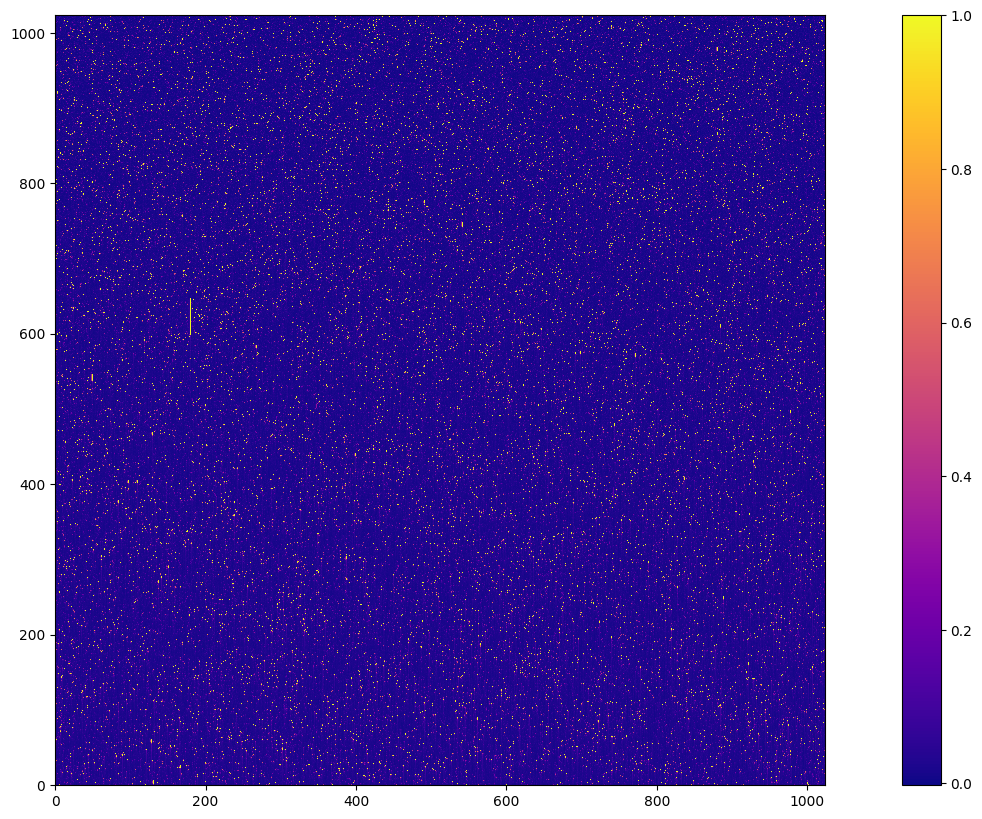

In [9]:
with fits.open(new_basedark) as hdu:
    new_basedark_data = hdu[1].data
cb = plt.imshow(new_basedark_data, cmap='plasma', vmax=1)
plt.colorbar(cb)

## Make Weekdark
The Weekdark is the combination of all "long" dark files from the week of the science observation, which is eventually passed into the Calstis pipline as the DARKFILE for the DARKCORR calibration. After the darks during a given week is combined and normalized to produce a weekly superdark, those hotpixels in the monthly Basedark are replaced by those of the normalized weekly superdark. The resulting dark has the high signal-to-noise ratio of the monthly baseline superdark, updated with the hot pixels of the current week.

We first search for the darks taken during the given week. We take the weekly period as the observation date ± 3 days in this demonstration, 
**but notice here that since the observation time is 2021-05-05 12:29:54 while the ending time of the annealing period is 2021-05-05 14:00:22, observation date + 3 days will cross the annealing boundary.** Therefore, in our case, we only take the observation date - 3 days as the weekly period. When you work with your own dataset, pay attention to the week boundary and annealing boundary to see if they completely overlap.

In [10]:
# search for darks taken during the weekly period (observation date, observation date + 3 days)
hdr = fits.getheader(crj, 0)
component_darks = Observations.query_criteria(
    target_name='DARK',
    t_min=[hdr['TEXPSTRT']-3, hdr['TEXPSTRT']],
    t_exptime=[1099, 1101])
# get a list of files assiciated with that target
dark_list = Observations.get_product_list(component_darks)
dark_list = dark_list[dark_list['productSubGroupDescription'] == 'FLT']
# store all the paths to the superdark frames into a list
component_flt = [filename_mapping[x] for x in component_darks['obs_id']]
component_flt

[np.str_('./mastDownload/HST/oeen9za2q/oeen9za2q_flt.fits'),
 np.str_('./mastDownload/HST/oeena0aaq/oeena0aaq_flt.fits'),
 np.str_('./mastDownload/HST/oeena1g5q/oeena1g5q_flt.fits'),
 np.str_('./mastDownload/HST/oeena2gcq/oeena2gcq_flt.fits'),
 np.str_('./mastDownload/HST/oeena3kjq/oeena3kjq_flt.fits'),
 np.str_('./mastDownload/HST/oeena4knq/oeena4knq_flt.fits')]

Now we have all the dark files we need to create the new weekdark reference file. Pass the list of the weekly component darks as the first parameter, the name of the new weekdark file as the second parameter, and the new basedark file we created above as the third parameter into refstis.make_weekdark. For more information on make_weekdark, see: [Weekdark](https://refstis.readthedocs.io/en/latest/api/weekdark.html).

In [11]:
new_weekdark = "new_weekdark.fits"
# remove the new_basedark file if it already exists
if os.path.exists(new_weekdark):
    os.remove(new_weekdark)
make_weekdark(component_flt, new_weekdark, thebasedark=new_basedark)

#-------------------------------#
#        Running weekdark       #
#-------------------------------#
Making weekdark new_weekdark.fits
With : oref$55a2044do_bia.fits
     : new_basedark.fits
BIAS correction already done for ./mastDownload/HST/oeen9za2q/oeen9za2q_flt.fits
BIAS correction already done for ./mastDownload/HST/oeena0aaq/oeena0aaq_flt.fits
BIAS correction already done for ./mastDownload/HST/oeena1g5q/oeena1g5q_flt.fits
BIAS correction already done for ./mastDownload/HST/oeena2gcq/oeena2gcq_flt.fits
BIAS correction already done for ./mastDownload/HST/oeena3kjq/oeena3kjq_flt.fits
BIAS correction already done for ./mastDownload/HST/oeena4knq/oeena4knq_flt.fits
TEMPCORR = COMPLETE, no temperature correction applied to ./mastDownload/HST/oeen9za2q/oeen9za2q_flt.fits
TEMPCORR = COMPLETE, no temperature correction applied to ./mastDownload/HST/oeena0aaq/oeena0aaq_flt.fits
TEMPCORR = COMPLETE, no temperature correction applied to ./mastDownload/HST/oeena1g5q/oeena1g5q_flt.fits
TEMP

Deleting old file: new_weekdark_joined_bd_calstis_log.txt
Running CalSTIS on new_weekdark_joined.fits
to create: new_weekdark_joined_crj.fits


Normalizing by  6600.0


hot pixels are defined as above:  0.104120255


Cleaning up...
Weekdark done for new_weekdark.fits


## Calibrate with New Weekdark
### Calibration
Now we have created the new weekdark reference file for our specific dataset, we can use it to calibrate the raw data using Calstis. To change the dark reference file, we first set the value of DARKFILE in the _raw data 0th header using fits.setval. Calstis will then look for the DARKFILE value and use it as the reference file for DARKCORR.

In [12]:
raw = os.path.join("./mastDownload/HST", "{}".format(obs_id), "{}_raw.fits".format(obs_id))
wav = os.path.join("./mastDownload/HST", "{}".format(obs_id), "{}_wav.fits".format(obs_id))

In [13]:
# set the value of DARKFILE to the filename of the new week dark
fits.setval(raw, ext=0, keyword='DARKFILE', value=new_weekdark)
# make sure that the value is set correctly
fits.getval(raw, ext=0, keyword='DARKFILE')

'new_weekdark.fits'

Calibrate the _raw data using the new weekdark reference file:

In [14]:
%%capture --no-stderr output

# create a new folder to store the calibrated data
if os.path.exists('./new_dark'):
    shutil.rmtree('./new_dark')
Path('./new_dark').mkdir(exist_ok=True)
res = stistools.calstis.calstis(raw, wavecal=wav, outroot="./new_dark/")
assert res == 0, 'CalSTIS returned an error!'


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    06-Nov-2025 16:05:52 UTC

Input    ./mastDownload/HST/oeik1s030/oeik1s030_raw.fits
Outroot  ./new_dark/oeik1s030_raw.fits
Wavecal  ./mastDownload/HST/oeik1s030/oeik1s030_wav.fits
Warning  DARKFILE is not the same in the science and wavecal headers; \
Warning  values in the science and wavecal are respectively: \
Warning  `new_weekdark.fits' \
Warning  `oref$55a20445o_drk.fits' \
Warning  The value from the science header will be used for the wavecal.

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    06-Nov-2025 16:05:52 UTC
Input    ./mastDownload/HST/oeik1s030/oeik1s030_raw.fits
Output   ./new_dark/oeik1s030_blv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G750L
DETECTOR CCD

Imset 1  Begin 16:05:52 UTC
Epcfile  oeik1snkj_epc.fits
Warning  EPCTAB `oeik1snkj_epc.fits' not found.

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=GROUND
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise value

         Bias level from overscan has been subtracted; \
         mean of bias levels subtracted was 1541.41.
BLEVCORR COMPLETE
         Uncertainty array initialized, readnoise=8.2328, gain=4.016

BIASCORR PERFORM
BIASCORR COMPLETE

DARKCORR OMIT

FLATCORR OMIT

SHADCORR OMIT
Imset 4  End 16:05:53 UTC

End      06-Nov-2025 16:05:53 UTC

*** CALSTIS-1 complete ***

*** CALSTIS-2 -- Version 3.4.2 (19-Jan-2018) ***
Begin    06-Nov-2025 16:05:53 UTC
Input    ./new_dark/oeik1s030_blv_tmp.fits
Output   ./new_dark/oeik1s030_crj_tmp.fits

CRCORR   PERFORM
Total number of input image sets = 4
CRREJTAB oref$j3m1403io_crr.fits


CRCORR   COMPLETE

End      06-Nov-2025 16:05:53 UTC

*** CALSTIS-2 complete ***

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    06-Nov-2025 16:05:53 UTC
Input    ./new_dark/oeik1s030_crj_tmp.fits
Output   ./new_dark/oeik1s030_crj.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G750L
DETECTOR CCD

Imset 1  Begin 16:05:53 UTC

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=GROUND
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise values---
CCDTAB   DESCRIP =Oct. 1996 Air Calibration

DQICORR  OMIT

ATODCORR OMIT

BLEVCORR OMIT

BIASCORR OMIT

DARKCORR PERFORM
DARKFILE new_weekdark.fits
DARKFILE PEDIGREE=INFLIGHT 03/05/2021 05/05/2021
DARKFILE DESCRIP =Weekly gain=1 dark for STIS CCD data taken after May 03 2021-------


DARKCORR COMPLETE

FLATCORR PERFORM
PFLTFILE oref$x6417096o_pfl.fits
PFLTFILE PEDIGREE=INFLIGHT 24/10/2011 24/06/2012
PFLTFILE DESCRIP =REVISED ON-ORBIT STIS SPECTROSCOPIC CCD P-FLAT FOR L-MODES---------
LFLTFILE oref$pcc2026ko_lfl.fits
LFLTFILE PEDIGREE=INFLIGHT 27/05/1997 27/05/1997
LFLTFILE DESCRIP =CCD G750L Low-Order Flat
FLATCORR COMPLETE

SHADCORR OMIT

PHOTCORR OMIT

STATFLAG PERFORM
STATFLAG COMPLETE


Imset 1  End 16:05:53 UTC

End      06-Nov-2025 16:05:53 UTC

*** CALSTIS-1 complete ***

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    06-Nov-2025 16:05:53 UTC
Input    ./new_dark/oeik1s030_blv_tmp.fits
Output   ./new_dark/oeik1s030_flt.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G750L
DETECTOR CCD

Imset 1  Begin 16:05:53 UTC
Epcfile  oeik1snkj_epc.fits
Warning  EPCTAB `oeik1snkj_epc.fits' not found.

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=GROUND
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise values---
CCDTAB   DESCRIP =Oct. 1996 Air Calibration

DQICORR  OMIT

ATODCORR OMIT

BLEVCORR OMIT

BIASCORR OMIT

DARKCORR PERFORM
DARKFILE new_weekdark.fits
DARKFILE PEDIGREE=INFLIGHT 03/05/2021 05/05/2021
DARKFILE DESCRIP =Weekly gain=1 dark for STIS CCD data taken after May 03 2021-------


DARKCORR COMPLETE

FLATCORR PERFORM
PFLTFILE oref$x6417096o_pfl.fits
PFLTFILE PEDIGREE=INFLIGHT 24/10/2011 24/06/2012
PFLTFILE DESCRIP =REVISED ON-ORBIT STIS SPECTROSCOPIC CCD P-FLAT FOR L-MODES---------
LFLTFILE oref$pcc2026ko_lfl.fits
LFLTFILE PEDIGREE=INFLIGHT 27/05/1997 27/05/1997
LFLTFILE DESCRIP =CCD G750L Low-Order Flat
FLATCORR COMPLETE

SHADCORR OMIT

PHOTCORR OMIT

STATFLAG PERFORM
STATFLAG COMPLETE


Imset 1  End 16:05:53 UTC

Imset 2  Begin 16:05:53 UTC
Epcfile  oeik1snlj_epc.fits
Warning  EPCTAB `oeik1snlj_epc.fits' not found.

DQICORR  OMIT

ATODCORR OMIT

BLEVCORR OMIT

BIASCORR OMIT

DARKCORR PERFORM


DARKCORR COMPLETE

FLATCORR PERFORM
FLATCORR COMPLETE

SHADCORR OMIT

STATFLAG PERFORM
STATFLAG COMPLETE


Imset 2  End 16:05:53 UTC

Imset 3  Begin 16:05:53 UTC
Epcfile  oeik1snmj_epc.fits
Warning  EPCTAB `oeik1snmj_epc.fits' not found.

DQICORR  OMIT

ATODCORR OMIT

BLEVCORR OMIT

BIASCORR OMIT

DARKCORR PERFORM
DARKCORR COMPLETE

FLATCORR PERFORM


FLATCORR COMPLETE

SHADCORR OMIT

STATFLAG PERFORM
STATFLAG COMPLETE
Imset 3  End 16:05:53 UTC

Imset 4  Begin 16:05:53 UTC
Epcfile  oeik1snnj_epc.fits


Warning  EPCTAB `oeik1snnj_epc.fits' not found.

DQICORR  OMIT

ATODCORR OMIT

BLEVCORR OMIT

BIASCORR OMIT

DARKCORR PERFORM
DARKCORR COMPLETE

FLATCORR PERFORM
FLATCORR COMPLETE

SHADCORR OMIT

STATFLAG PERFORM
STATFLAG COMPLETE


Imset 4  End 16:05:54 UTC

End      06-Nov-2025 16:05:54 UTC

*** CALSTIS-1 complete ***

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    06-Nov-2025 16:05:54 UTC
Input    ./mastDownload/HST/oeik1s030/oeik1s030_wav.fits
Output   ./new_dark/oeik1s030_fwv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X0.1
OPT_ELEM G750L
DETECTOR CCD

Imset 1  Begin 16:05:54 UTC
Epcfile  oeik1snoj_epc.fits
Warning  EPCTAB `oeik1snoj_epc.fits' not found.

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=GROUND
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise values---
CCDTAB   DESCRIP =Oct. 1996 Air Calibration

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM


         Bias level from overscan has been subtracted; \
         mean of bias levels subtracted was 1540.52.
BLEVCORR COMPLETE
         Uncertainty array initialized, readnoise=8.2328, gain=4.016

BIASCORR PERFORM
BIASFILE oref$55a20443o_bia.fits
BIASFILE PEDIGREE=INFLIGHT 22/04/2021 05/05/2021
BIASFILE DESCRIP =Refbias (4/D) for data taken after 2021-04-21----------------------
BIASCORR COMPLETE

DARKCORR PERFORM
DARKFILE new_weekdark.fits
DARKFILE PEDIGREE=INFLIGHT 03/05/2021 05/05/2021
DARKFILE DESCRIP =Weekly gain=1 dark for STIS CCD data taken after May 03 2021-------
DARKCORR COMPLETE

FLATCORR PERFORM
PFLTFILE oref$x6417096o_pfl.fits
PFLTFILE PEDIGREE=INFLIGHT 24/10/2011 24/06/2012
PFLTFILE DESCRIP =REVISED ON-ORBIT STIS SPECTROSCOPIC CCD P-FLAT FOR L-MODES---------
LFLTFILE oref$pcc2026ko_lfl.fits
LFLTFILE PEDIGREE=INFLIGHT 27/05/1997 27/05/1997
LFLTFILE DESCRIP =CCD G750L Low-Order Flat
FLATCORR COMPLETE

SHADCORR OMIT

PHOTCORR OMIT

STATFLAG PERFORM


STATFLAG COMPLETE
Imset 1  End 16:05:54 UTC

End      06-Nov-2025 16:05:54 UTC

*** CALSTIS-1 complete ***

*** CALSTIS-7 -- Version 3.4.2 (19-Jan-2018) ***
Begin    06-Nov-2025 16:05:54 UTC
Input    ./new_dark/oeik1s030_fwv_tmp.fits
Output   ./new_dark/oeik1s030_w2d_tmp.fits
OBSMODE  ACCUM
APERTURE 52X0.1
OPT_ELEM G750L
DETECTOR CCD
Imset 1  Begin 16:05:54 UTC

Order 1  Begin 16:05:54 UTC



X2DCORR  PERFORM
DISPCORR PERFORM
APDESTAB oref$16j16005o_apd.fits
APDESTAB PEDIGREE=INFLIGHT 01/03/1997 13/06/2017
APDESTAB DESCRIP =Aligned long-slit bar positions for single-bar cases.--------------
APDESTAB DESCRIP =Microscope Meas./Hartig Post-launch Offsets
SDCTAB   oref$16j16006o_sdc.fits
SDCTAB   PEDIGREE=INFLIGHT 27/05/1997 13/06/2017
SDCTAB   DESCRIP =Co-aligned fiducial bars via an update to the CDELT2 plate scales.-
SDCTAB   DESCRIP =CDELT2 updated with inflight data, others Lindler/prelaunch
DISPTAB  oref$l2j0137to_dsp.fits
DISPTAB  PEDIGREE=INFLIGHT 27/02/1997 24/11/1999
DISPTAB  DESCRIP =Lindler, May 2000
DISPTAB  DESCRIP =Lindler Postlaunch, May 2000
INANGTAB oref$h5s11397o_iac.fits
INANGTAB PEDIGREE=GROUND
INANGTAB DESCRIP =Model/C. Bowers May 6, 1997
INANGTAB DESCRIP =Model/C. Bowers
SPTRCTAB oref$qa31608go_1dt.fits
SPTRCTAB PEDIGREE=INFLIGHT 13/02/1998
SPTRCTAB DESCRIP =New traces to account for angle change with time
SPTRCTAB DESCRIP =Lindler/Bohlin/Dressel/Holfelt

         Shift in dispersion direction is 2.957 pixels.
         Shift in spatial direction is -1.950 pixels.
WAVECORR COMPLETE
Imset 1  End 16:05:54 UTC

End      06-Nov-2025 16:05:54 UTC

*** CALSTIS-4 complete ***

*** CALSTIS-12 -- Version 3.4.2 (19-Jan-2018) ***
Begin    06-Nov-2025 16:05:54 UTC
Wavecal  ./new_dark/oeik1s030_w2d_tmp.fits
Science  ./new_dark/oeik1s030_crj.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G750L
DETECTOR CCD
Imset 1  Begin 16:05:54 UTC
         SHIFTA1 set to 2.95707
         SHIFTA2 set to -1.94995
Imset 1  End 16:05:54 UTC

End      06-Nov-2025 16:05:54 UTC

*** CALSTIS-12 complete ***

*** CALSTIS-12 -- Version 3.4.2 (19-Jan-2018) ***
Begin    06-Nov-2025 16:05:54 UTC
Wavecal  ./new_dark/oeik1s030_w2d_tmp.fits
Science  ./new_dark/oeik1s030_flt.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G750L
DETECTOR CCD
Imset 1  Begin 16:05:54 UTC
         SHIFTA1 set to 2.95707
         SHIFTA2 set to -1.94995
Imset 1  End 16:05:54 UTC
Imset 2  Begin 16:05:54 UTC
     


X2DCORR  PERFORM
DISPCORR PERFORM
APDESTAB oref$16j16005o_apd.fits
APDESTAB PEDIGREE=INFLIGHT 01/03/1997 13/06/2017
APDESTAB DESCRIP =Aligned long-slit bar positions for single-bar cases.--------------
APDESTAB DESCRIP =Microscope Meas./Hartig Post-launch Offsets
SDCTAB   oref$16j16006o_sdc.fits
SDCTAB   PEDIGREE=INFLIGHT 27/05/1997 13/06/2017
SDCTAB   DESCRIP =Co-aligned fiducial bars via an update to the CDELT2 plate scales.-
SDCTAB   DESCRIP =CDELT2 updated with inflight data, others Lindler/prelaunch
DISPTAB  oref$l2j0137to_dsp.fits
DISPTAB  PEDIGREE=INFLIGHT 27/02/1997 24/11/1999
DISPTAB  DESCRIP =Lindler, May 2000
DISPTAB  DESCRIP =Lindler Postlaunch, May 2000
INANGTAB oref$h5s11397o_iac.fits
INANGTAB PEDIGREE=GROUND
INANGTAB DESCRIP =Model/C. Bowers May 6, 1997
INANGTAB DESCRIP =Model/C. Bowers
SPTRCTAB oref$qa31608go_1dt.fits
SPTRCTAB PEDIGREE=INFLIGHT 13/02/1998
SPTRCTAB DESCRIP =New traces to account for angle change with time
SPTRCTAB DESCRIP =Lindler/Bohlin/Dressel/Holfelt

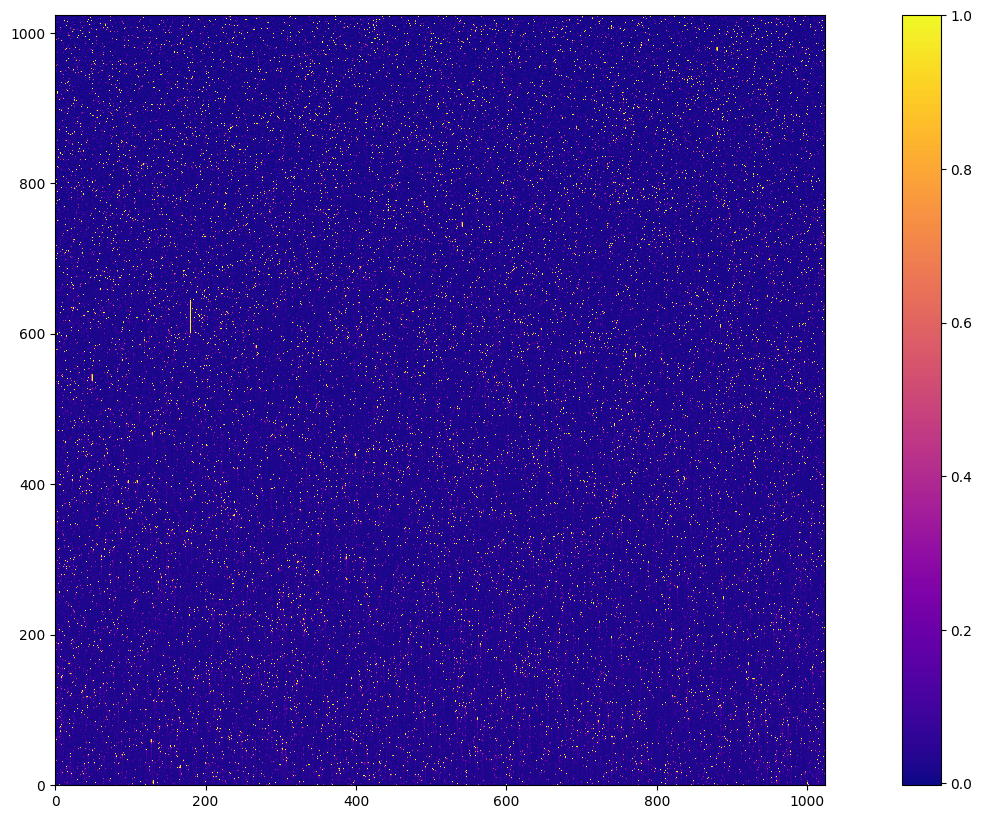

In [15]:
with fits.open('new_weekdark.fits') as hdu:
    new_weekdark_data = hdu[1].data
cb = plt.imshow(new_weekdark_data, cmap='plasma', vmax=1)
plt.colorbar(cb)

To compare the new weekdark science image with the old weekdark science image, we divide the new weekdark science image frame by that of the old weekdark, and use a diverging colormap to visulize the ratio. The colormap is normalized to center at 1, and the red pixels suggests that the ratio is greater than 1 while the blue pixels suggests that the ratio is less than 1. In general there are more blue pixels in the image, which means we are removing more hot pixels compared with the old weekdark.

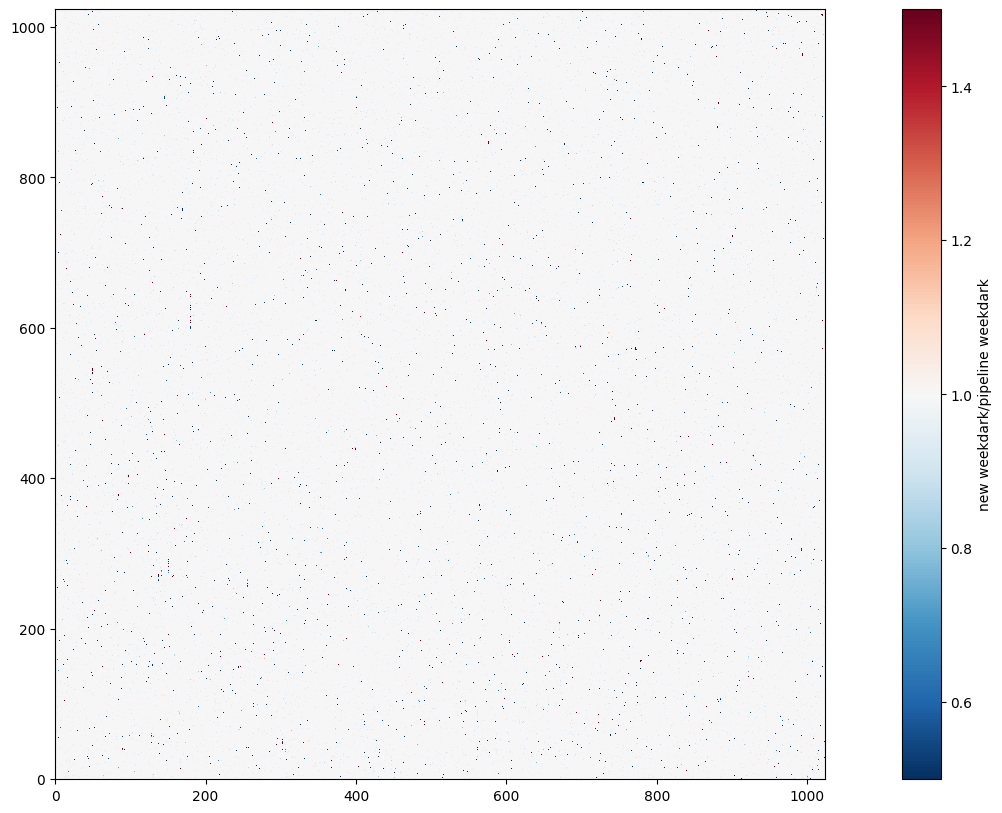

In [16]:
with fits.open("55a20445o_drk.fits") as hdu:
    old_weekdark_data = hdu[1].data
cb = plt.imshow(new_weekdark_data/old_weekdark_data, cmap='RdBu_r', vmin=0.5, vmax=1.5)
plt.colorbar(cb, label="new weekdark/pipeline weekdark")

### Comparison With the Default Dark File
When we collected the science data from MAST, the _crj and _sx1 data files are already calibrated using the default dark reference file. We can make a comparison between the calibrated images and spectra of the defualt dark file and our new Weekdark. As shown in the comparison, a hot pixel is removed from the _crj image at x $\approx$ 605 and y $\approx$ 185.

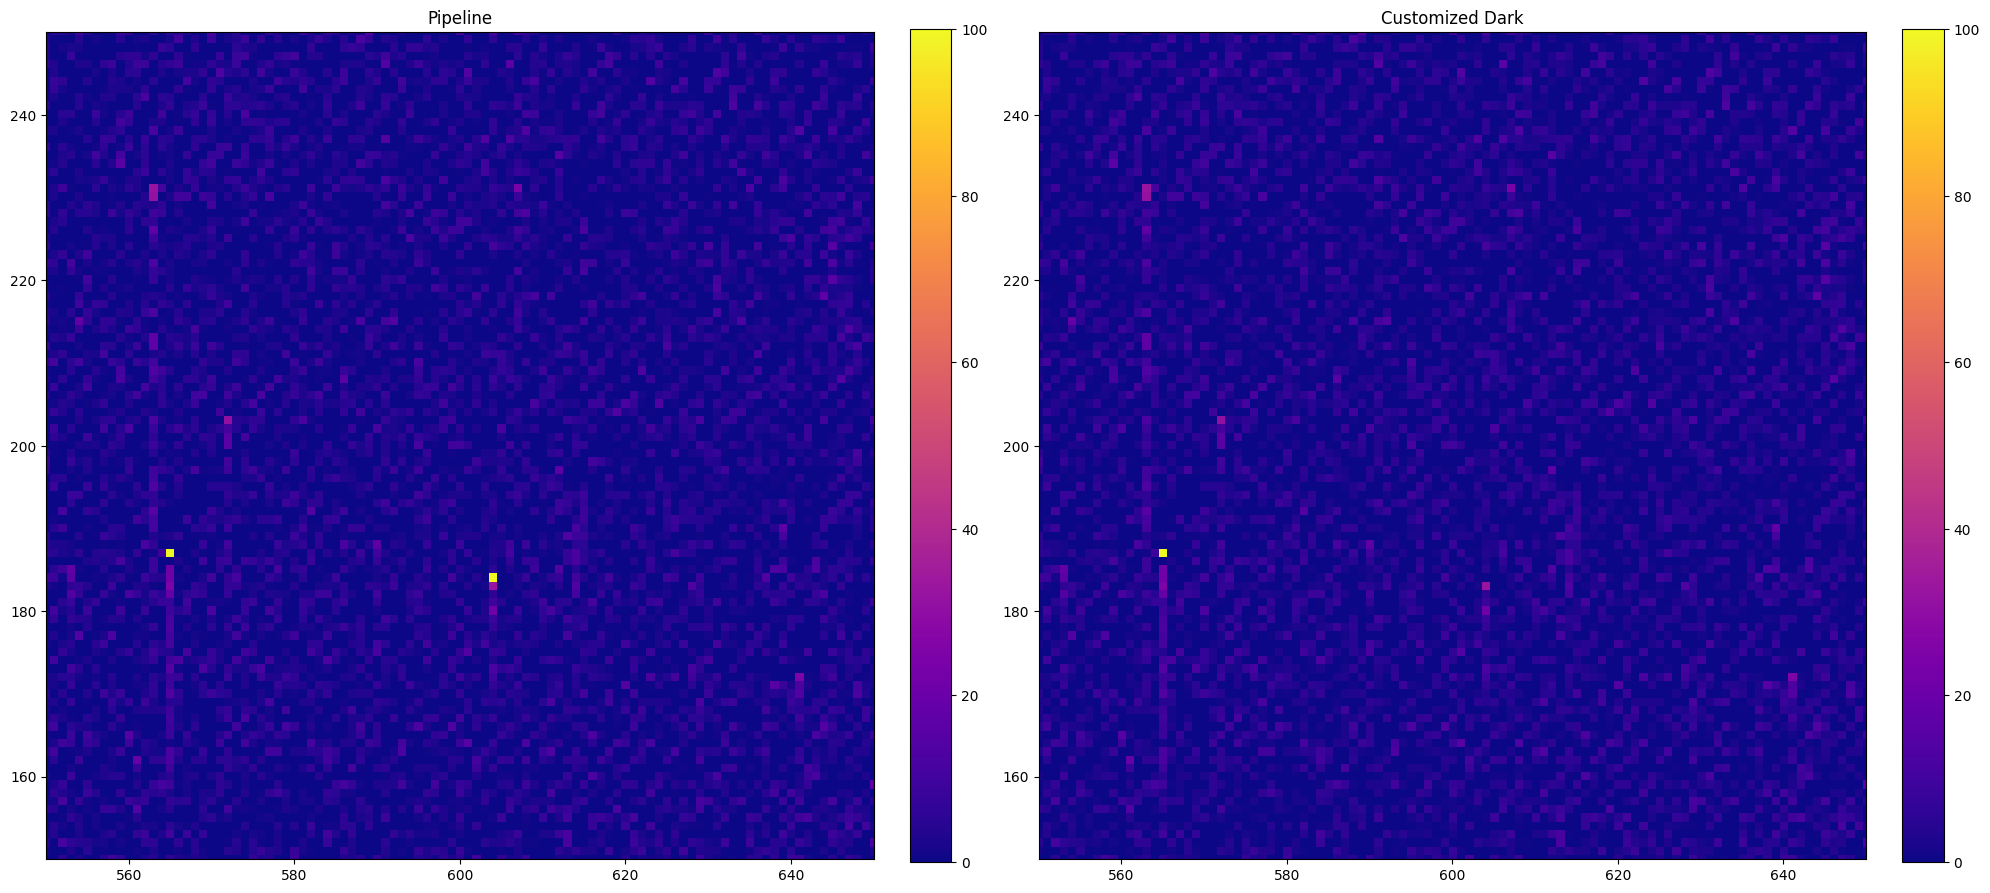

In [17]:
# Plot the calibrated _crj images
# The left panel is the defalt _crj image from the pipline
# the right panel is calibrated with our customized dark file
plt.subplot(1, 2, 1)
with fits.open(crj) as hdu:
    ex1 = hdu[1].data
    cb = plt.imshow(ex1, vmin=0, vmax=100)
    plt.colorbar(cb, fraction=0.046, pad=0.04)
    plt.xlim(550, 650)
    plt.ylim(150, 250)
    plt.title("Pipeline")
plt.subplot(1, 2, 2)
with fits.open("./new_dark/oeik1s030_crj.fits") as hdu:
    ex1 = hdu[1].data
    cb = plt.imshow(ex1, vmin=0, vmax=100)
    plt.colorbar(cb, fraction=0.046, pad=0.04)
    plt.xlim(550, 650)
    plt.ylim(150, 250)
    plt.title("Customized Dark")
plt.tight_layout()

We can also visualize the flux difference in the _sx1 spectra in which we substrct the recalibrated spectrum by the pipeline spectrum:

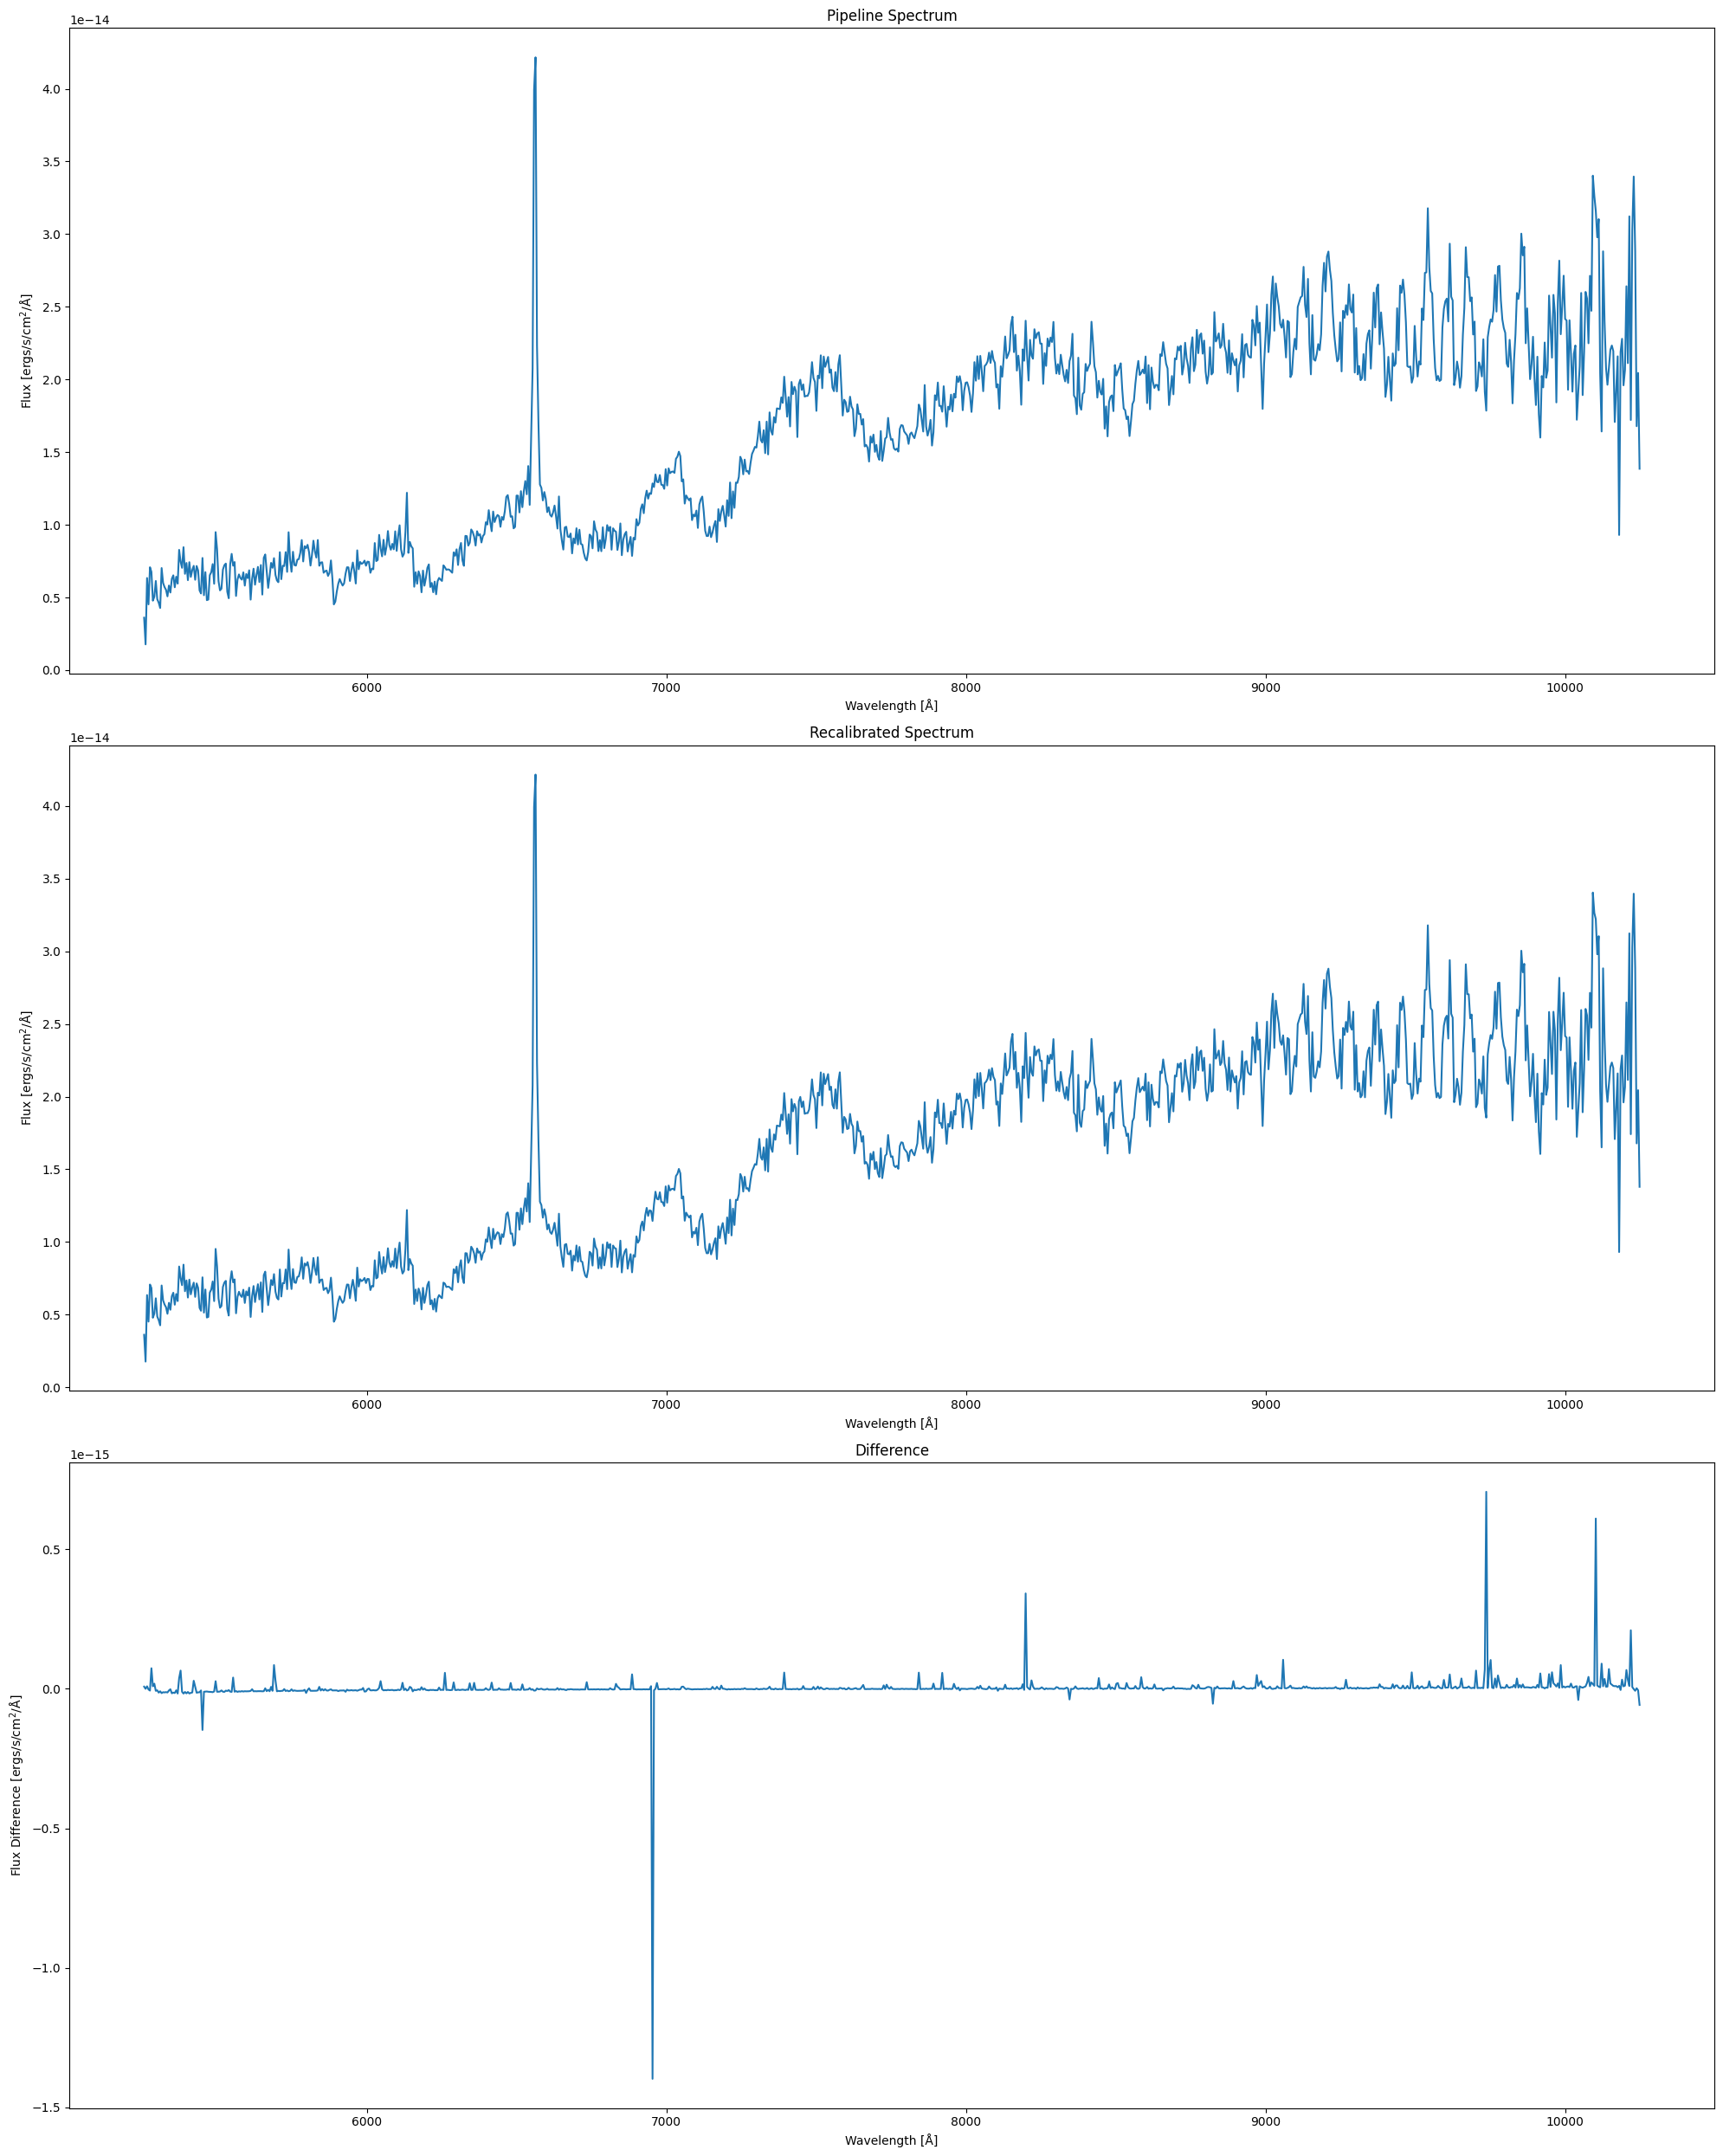

In [18]:
plt.figure(figsize=(20, 25))
# get the spectrum of the default pipline _sx1 data
pip = Table.read("./mastDownload/HST/oeik1s030/oeik1s030_sx1.fits", 1)
wl, pip_flux = pip[0]["WAVELENGTH", "FLUX"]
# get the flux of the customized new_dark _sx1 data
cus = Table.read("./new_dark/oeik1s030_sx1.fits", 1)
cus_wl, cus_flux = cus[0]["WAVELENGTH", "FLUX"]
# interpolant flux so that the wavelengths matches
interp_flux = np.interp(wl, cus_wl, cus_flux)
# plot the pipeline spectrum
plt.subplot(3, 1, 1)
plt.plot(wl, pip_flux)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [ergs/s/cm$^2$/Å]")
plt.title("Pipeline Spectrum")
# plot the pipeline spectrum
plt.subplot(3, 1, 2)
plt.plot(cus_wl, cus_flux)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [ergs/s/cm$^2$/Å]")
plt.title("Recalibrated Spectrum")
# plot the spectra difference
plt.subplot(3, 1, 3)
plt.plot(wl, interp_flux-pip_flux)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux Difference [ergs/s/cm$^2$/Å]")
plt.title("Difference")
plt.tight_layout()


---
## About this Notebook <a class="tocSkip">
**Author:** Keyi Ding

**Updated On:** 2025-11-05


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations <a class="tocSkip">

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)

<hr>

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 